In [1]:
import h5py
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from pycbc.conversions import eta_from_mass1_mass2, mchirp_from_mass1_mass2, mass1_from_mchirp_eta, mass2_from_mchirp_eta

In [2]:
data = h5py.File('H1L1V1-BANKSIM_MATCH_COMBINE_BROADINJ1-2620801-1163865616.h5', 'r')
data['inj_params'].keys()

<KeysViewHDF5 ['coa_phase', 'inclination', 'latitude', 'longitude', 'mass1', 'mass2', 'polarization', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z']>

In [3]:
m1 = data['inj_params']['mass1'][:]
m2 = data['inj_params']['mass2'][:]
chi1= data['inj_params']['spin1z'][:]
chi2 = data['inj_params']['spin2z'][:]
match = data['trig_params']['match'][:]
mchirp = mchirp_from_mass1_mass2(m1, m2)
eta = eta_from_mass1_mass2(m1, m2)

In [4]:
#sel = np.logical_and(eta < 0.249, np.logical_and(eta > 0.1, np.logical_and(mchirp >5, mchirp < 50)))

sel = np.logical_and(eta > 0.1, np.logical_and(mchirp >5, mchirp < 20))

constrained_m1 = m1[sel]
constrained_m2=m2[sel]
constrained_chi1=chi1[sel]
constrained_chi2=chi2[sel]
constrained_match=match[sel]
constrained_mchirp=mchirp[sel]
constrained_eta=eta[sel]

In [5]:
print(f'There is a total of {len(constrained_m1)} injections.')

There is a total of 7446 injections.


In [6]:
print(f'There were {len(constrained_m1[constrained_match < 0.97])} injections that were not recovered and had fitting factors less than 0.97.')

There were 130 injections that were not recovered and had fitting factors less than 0.97.


In [7]:
print(f'{(len(constrained_m1)-len(constrained_m1[constrained_match < 0.97]))/(len(constrained_m1))*100} of injections were recovered at with a fitting factor greater than 0.97.')

98.25409615901155 of injections were recovered at with a fitting factor greater than 0.97.


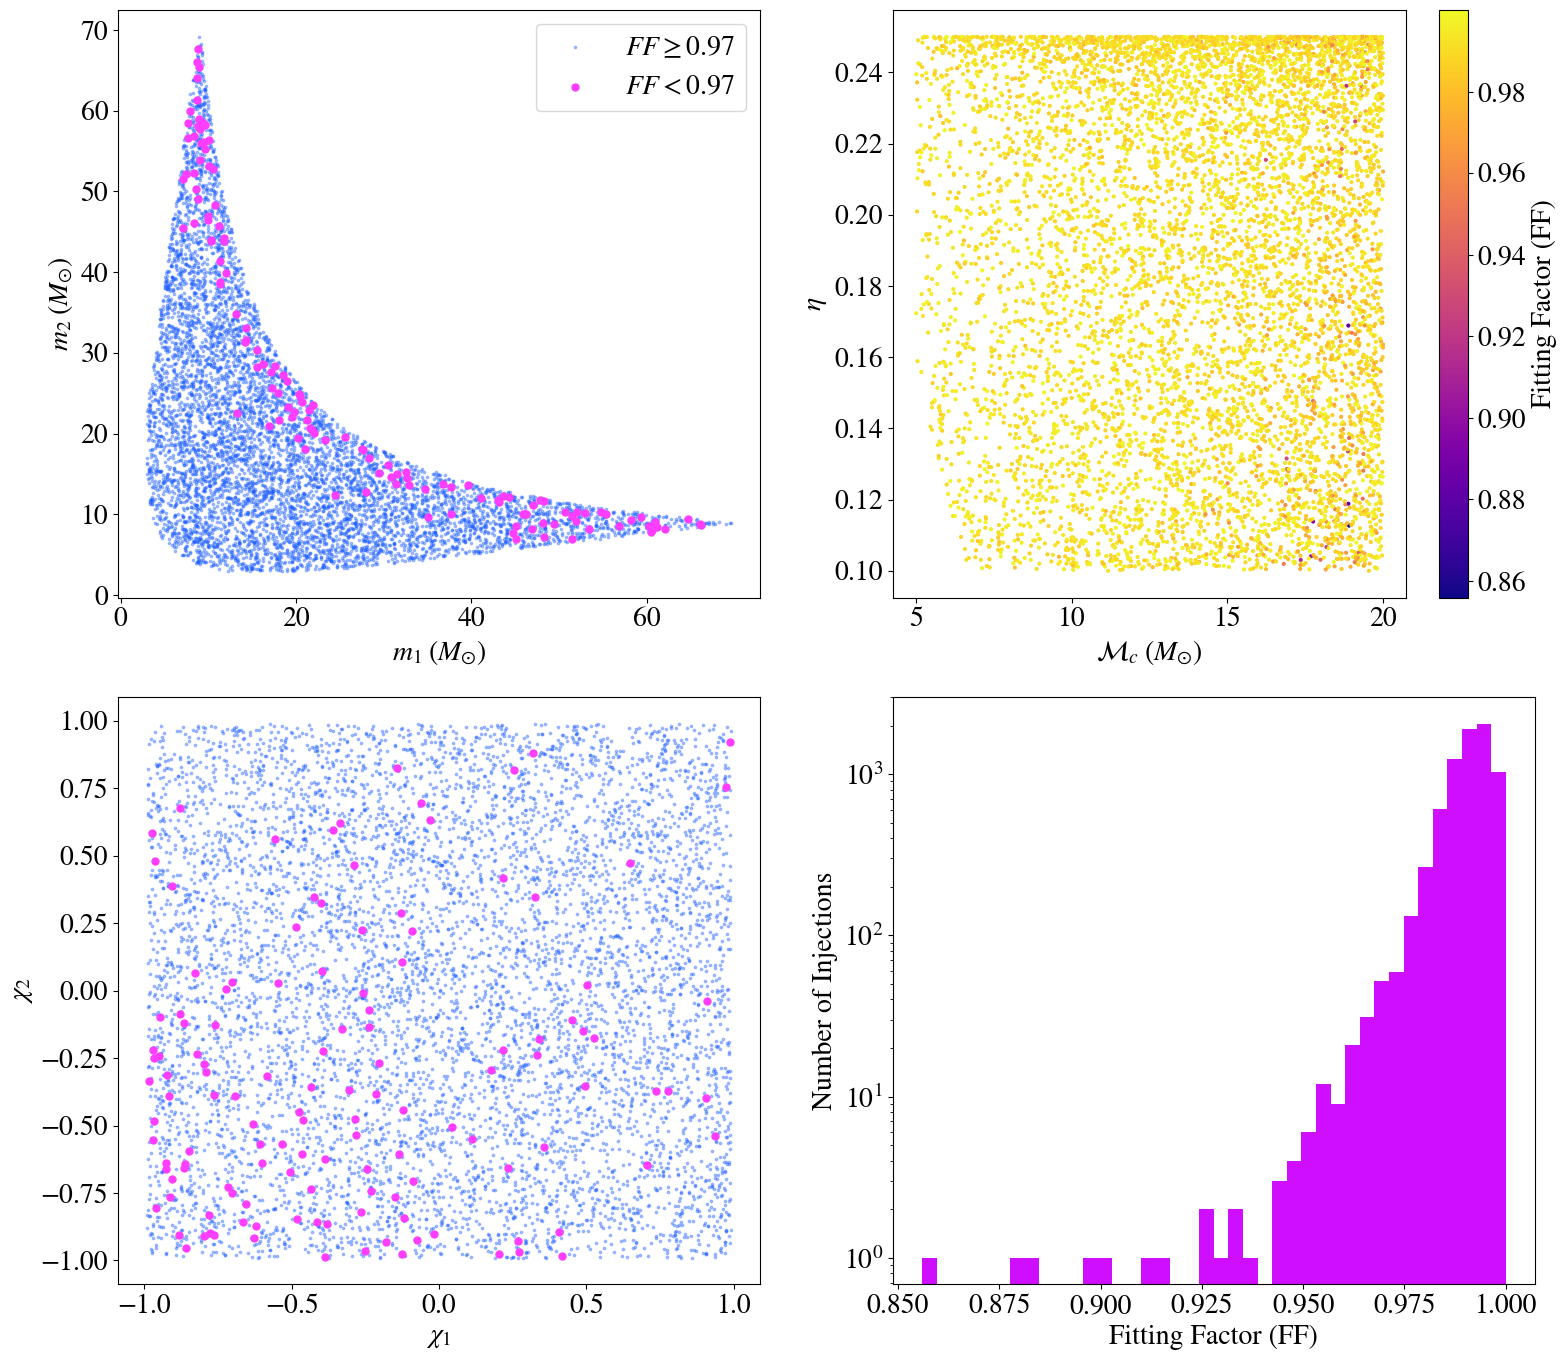

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

ax1.scatter(constrained_m1[constrained_match >= 0.97], constrained_m2[constrained_match >= 0.97], color='#1c5dff', s=3, alpha=0.35, label='$FF \geq 0.97$')
ax1.scatter(constrained_m1[constrained_match < 0.97], constrained_m2[constrained_match < 0.97], color='#fe3dfd', s=25, label='$FF < 0.97$')
ax1.set_xlabel('$m_{1} \; (M_{\odot})$')
ax1.set_ylabel('$m_{2} \; (M_{\odot})$')
ax1.legend()

ax2.scatter(constrained_mchirp, constrained_eta, c=constrained_match, s=3, cmap='plasma')
ax2.set_xlabel('$\mathcal{M}_{c} \; (M_{\odot})$')
ax2.set_ylabel('$\eta$')


ax3.scatter(constrained_chi1[constrained_match >= 0.97], constrained_chi2[constrained_match >= 0.97], color='#1c5dff', s=3, alpha=0.35)
ax3.scatter(constrained_chi1[constrained_match < 0.97], constrained_chi2[constrained_match < 0.97], color='#fe3dfd', s=25)
ax3.set_xlabel('$\chi_{1}$')
ax3.set_ylabel('$\chi_{2}$')

ax4.hist(constrained_match, color='#cf0dff', bins=40)
ax4.set_xlabel('Fitting Factor (FF)')
ax4.set_ylabel('Number of Injections')
ax4.set_yscale('log')


fig.colorbar(ax2.scatter(constrained_mchirp, constrained_eta, c=constrained_match, s=3, cmap='plasma'), label='Fitting Factor (FF)')
fig.tight_layout() 
fig.savefig('Results_Big.png', dpi=300, bbox_inches='tight')

<h1>Identifying why the template bank was undercovered in the high mass regions<h1> 

In [9]:
from Model import NeuralNetwork
import torch
import torch.nn as nn
import pandas as pd

In [10]:
#Locate the trained LearningMatch model
LEARNINGMATCH_MODEL = '/users/sgreen/TemplateGeNN/Paper/LearningMatchModel.pth'

In [11]:
#Define the functions
REF_LAMBDA = 5.0

def lambda0_to_mchirp(lambda0):
    return (lambda0**(-3/5))*REF_LAMBDA

def mchirp_to_lambda0(mchirp):
    return (mchirp/REF_LAMBDA)**(-5/3)

In [12]:
#Check that Pytorch recognises there is a GPU available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
#Load the trained LearningMatch model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(LEARNINGMATCH_MODEL, map_location=device))
model.eval()

NeuralNetwork(
  (embed): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=16, bias=True)
  )
  (crunch): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [14]:
#Locate the template bank generated by TemplateGeNN using the learningMatch model loaded in the cell above. 
TEMPLATEBANK_FILE_PATH = '/users/sgreen/TemplateGeNN/Paper/TemplateGeNN.csv'
TemplateBank = pd.read_csv(TEMPLATEBANK_FILE_PATH)
TemplateBank.head()

,mass1,mass2,spin1,spin2
0,10.641979,4.064587,-0.951018,-0.951018
1,14.312708,4.584690,0.929297,0.929297
2,19.776701,5.136718,-0.504790,-0.504790
3,16.326553,3.723757,0.427425,0.427425
4,18.421391,5.056704,-0.804766,-0.804766


In [15]:
#Convert the template bank generated by TemplateGeNN into the parameter space for LearningMatch. 
template_bank_mchirp = mchirp_from_mass1_mass2(TemplateBank.mass1.values, TemplateBank.mass2.values)
template_bank_lambda0 = mchirp_to_lambda0(template_bank_mchirp)
template_bank_eta = eta_from_mass1_mass2(TemplateBank.mass1.values, TemplateBank.mass2.values)

template_bank = np.vstack((template_bank_lambda0, template_bank_eta,
                   TemplateBank.spin1.values, TemplateBank.spin2.values)).T

In [16]:
#Convert the template bank to a tensor.
template_bank_tensor = torch.tensor(template_bank, dtype=torch.float32)

#Define the size of the template bank.
rows, columns = template_bank_tensor.size()

In [17]:
#Create variables for all the injections that were not recovered by the template bank generated by TemplateGeNN.
failed_injections_mchirp = constrained_mchirp[constrained_match < 0.97]
failed_injections_eta = constrained_eta[constrained_match < 0.97]
failed_injections_chi1 = constrained_chi1[constrained_match < 0.97]
failed_injections_chi2 = constrained_chi2[constrained_match < 0.97]

failed_injections = np.vstack((mchirp_to_lambda0(failed_injections_mchirp), failed_injections_eta, 
                     failed_injections_chi1, failed_injections_chi2)).T

In [18]:
#Iterate through each injection that was not recovered by the template bank generated by TemplateGeNN, called failed injections. 
#Let LearningMatch predict the match between the failed injections and the template bank. 
#Find the maximum match (i.e. fitting factor) which we have called the LearningMatch Predictive Fitting Factor.
learningMatch_failed = []
for x in failed_injections: 
    failed_injections_tensor = torch.tensor(x, dtype=torch.float32)
    ref_parameters = torch.reshape(failed_injections_tensor, (1,-1))
    large_ref_parameters = failed_injections_tensor.expand(rows, 4)
    x_data =  torch.cat((large_ref_parameters, template_bank_tensor), 1)
    match = model(x_data)
    learningMatch_failed.append(torch.max(match).detach().numpy())

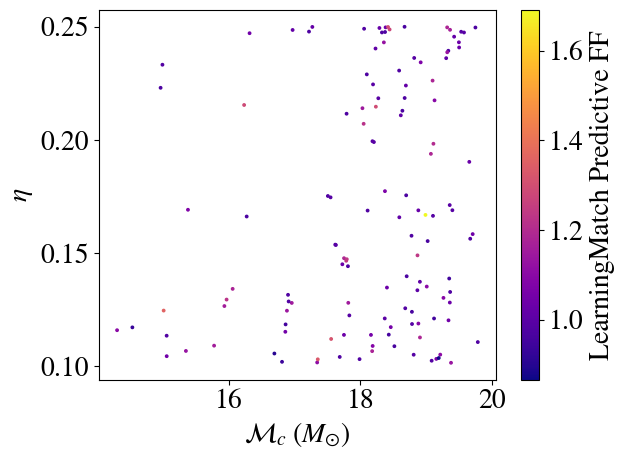

In [19]:
plt.scatter(failed_injections_mchirp, failed_injections_eta, c=learningMatch_failed, s=3, cmap='plasma')
plt.xlabel('$\mathcal{M}_{c} \; (M_{\odot})$')
plt.ylabel('$\eta$')
plt.colorbar(label='LearningMatch Predictive FF')
plt.savefig('LearningMatch_failed_injections_scatter.png', dpi=300, bbox_inches='tight')